In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from aSPEM import aSPEM
import bayesianchangepoint as bcp

%matplotlib inline

In [2]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

In [3]:
Full = e.Full_list(modes_bcp=[])

In [4]:
def mutual_information(p, data, bin_p=20, bin_data=30):
    
    x = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    y = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    support_x = np.linspace(min(x), max(x), bin_p)
    support_y = np.linspace(min(y), max(y), int(len(data)/bin_data))

    summation = 0.00
    for a in range(len(support_x)-1):
        for b in range(len(support_y)-1):
            ind_x = np.where((x>=support_x[a]) & (x<=support_x[a+1]))[0]
            ind_y = np.where((y>=support_y[b]) & (y<=support_y[b+1]))[0]

            px = len(ind_x) / len(x)
            py = len(ind_y) / len(x)
            pxy = len(np.where(np.in1d(ind_x, ind_y)==True)[0]) / len(x)

            if pxy>0.00: summation += pxy * np.log2(pxy / (px*py))


    return summation

In [5]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_


In [6]:
def plot(regress='MI') :
    modes_bcp = 'mean'
    list_h = np.geomspace(0.0025, 0.25, 21)

    fig, ax = plt.subplots(4,3,figsize=(10*4,10*3))
    for a, t in zip(range(4), [regress+' sujet', regress+' block', regress+' pause', regress+' 100']) :
        ax[a][0].set_title(t, fontsize=30)
        ax[a][0].set_xlabel('$h_{bet}$', fontsize=20)
        ax[a][0].set_ylabel('$h_{va}$', fontsize=20)
        
        ax[a][1].set_title(t+' va', fontsize=30)
        ax[a][2].set_title(t+' bet', fontsize=30)
        for b in range(1, 3) :
            ax[a][b].set_xlabel('h', fontsize=20)
            ax[a][b].set_ylabel('MI', fontsize=20)




    COLOR = ['b', 'r', 'k', 'g', 'm', 'c',
             'darkblue', 'darkred', 'peru', 'darkgreen', 'darkmagenta', 'darkcyan']


    for num, s in enumerate(set(Full.sujet)) :
        print(s, end=' ')
        va = Full['va'][Full.sujet==s].values.tolist()
        bet = Full['results'][Full.sujet==s].values.tolist()
        x = np.array(Full['bino'][Full.sujet==s].values.tolist())

        mi_va_s, mi_bet_s = [], []
        mi_va_b, mi_bet_b = [], []
        mi_va_p, mi_bet_p = [], []
        mi_va_100, mi_bet_100 = [], []
        for b in range(3):
            mi_va_b.append([]) ; mi_bet_b.append([])
            mi_va_p.append([]) ; mi_bet_p.append([])
            
            liste = [0, 50, 100, 150, 200]
            for a in range(len(liste)-1) : mi_va_p[b].append([]) ; mi_bet_p[b].append([])
            
        for c in range(0, 3*200-50, 50) : mi_va_100.append([]) ; mi_bet_100.append([])
            
        h_va_b, h_bet_b = [], []
        h_va_p, h_bet_p = [], []
        h_va_100, h_bet_100 = [], []

        for num_h, h in enumerate(list_h) :
            p_hat_s = np.zeros(len(x))

            for b in range(3):
                nb = 200*b
                p_hat_b = np.zeros(200)

                liste = [0, 50, 100, 150, 200]
                for a in range(len(liste)-1) :
                    p_bar, r_bar, beliefs = bcp.inference(x[nb+liste[a]:nb+liste[a+1]], h=h, p0=.5, r0=1.)
                    p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)

                    p_hat_b[liste[a]:liste[a+1]] = p_hat_p
                    p_hat_s[nb+liste[a]:nb+liste[a+1]] = p_hat_p

                    if regress=='MI' :
                        miva_p = mutual_information(p_hat_p.tolist(), va[nb+liste[a]:nb+liste[a+1]], bin_p=20, bin_data=2.5)
                        mibet_p = mutual_information(p_hat_p.tolist(), bet[nb+liste[a]:nb+liste[a+1]], bin_p=20, bin_data=2.5)
                    else :
                        miva_p = r_(p_hat_p.tolist(), va[nb+liste[a]:nb+liste[a+1]])
                        mibet_p = r_(p_hat_p.tolist(), bet[nb+liste[a]:nb+liste[a+1]])
                        
                    mi_va_p[b][a].append(miva_p)
                    mi_bet_p[b][a].append(mibet_p)

                if regress=='MI' :
                    miva_b = mutual_information(p_hat_b.tolist(), va[nb:nb+200], bin_p=20, bin_data=10)
                    mibet_b = mutual_information(p_hat_b.tolist(), bet[nb:nb+200], bin_p=20, bin_data=10)

                else :
                    miva_b = r_(p_hat_b.tolist(), va[nb:nb+200])
                    mibet_b = r_(p_hat_b.tolist(), bet[nb:nb+200])

                mi_va_b[b].append(miva_b)
                mi_bet_b[b].append(mibet_b)


            for d, c in enumerate(range(0, 3*200-50, 50)) :
                x_100 = x[c:c+100]
                p_hat_100 = np.zeros(100)

                liste = [0, 50, 100]
                for a in range(len(liste)-1) :
                    p_bar, r_bar, beliefs = bcp.inference(x_100[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                    p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                    p_hat_100[liste[a]:liste[a+1]] = p_hat_p

                if regress=='MI' :
                    miva_100 = mutual_information(p_hat_100.tolist(), va[c:c+100], bin_p=20, bin_data=5)
                    mibet_100 = mutual_information(p_hat_100.tolist(), bet[c:c+100], bin_p=20, bin_data=5)
                else :
                    miva_100 = r_(p_hat_100.tolist(), va[c:c+100])
                    mibet_100 = r_(p_hat_100.tolist(), bet[c:c+100])

                mi_va_100[d].append(miva_100)
                mi_bet_100[d].append(mibet_100)

            if regress=='MI' :
                miva_s = mutual_information(p_hat_s.tolist(), va, bin_p=20, bin_data=30)
                mibet_s = mutual_information(p_hat_s.tolist(), bet, bin_p=20, bin_data=30)

            else :
                miva_s = r_(p_hat_s.tolist(), va)
                mibet_s = r_(p_hat_s.tolist(), bet)

                
            mi_va_s.append(miva_s)
            mi_bet_s.append(mibet_s)

        for b in range(3):
            h_va_b.append(list_h[np.argmax(mi_va_b[b])])
            h_bet_b.append(list_h[np.argmax(mi_bet_b[b])])
            
            liste = [0, 50, 100, 150, 200]
            for a in range(len(liste)-1) :
                h_va_p.append(list_h[np.argmax(mi_va_p[b][a])])
                h_bet_p.append(list_h[np.argmax(mi_bet_p[b][a])])
                #ax[2][1].plot(list_h, mi_va_p[b][a], c=COLOR[num])
                #ax[2][2].plot(list_h, mi_bet_p[b][a], c=COLOR[num])  
            
            ax[2][1].plot(list_h+0.001*num, np.mean(mi_va_p[b], axis=0), c=COLOR[num])
            ax[2][1].errorbar(list_h+0.001*num, np.mean(mi_va_p[b], axis=0), yerr=np.std(mi_va_p[b], axis=0), c=COLOR[num])
                        
            ax[2][2].plot(list_h+0.001*num, np.mean(mi_bet_p[b], axis=0), c=COLOR[num])
            ax[2][2].errorbar(list_h+0.001*num, np.mean(mi_bet_p[b], axis=0), yerr=np.std(mi_bet_p[b], axis=0), c=COLOR[num])

                
        for d, c in enumerate(range(0, 3*200-50, 50)) :
            h_va_100.append(list_h[np.argmax(mi_va_100[d])])
            h_bet_100.append(list_h[np.argmax(mi_bet_100[d])])
            #ax[3][1].plot(list_h, mi_va_100[d], c=COLOR[num])
            #ax[3][2].plot(list_h, mi_bet_100[d], c=COLOR[num])

        
        ax[3][1].plot(list_h+0.001*num, np.mean(mi_va_100, axis=0), c=COLOR[num])
        ax[3][1].errorbar(list_h+0.001*num, np.mean(mi_va_100, axis=0), yerr=np.std(mi_va_100, axis=0), c=COLOR[num])

        ax[3][2].plot(list_h+0.001*num, np.mean(mi_bet_100, axis=0), c=COLOR[num])
        ax[3][2].errorbar(list_h+0.001*num, np.mean(mi_bet_100, axis=0), yerr=np.std(mi_bet_100, axis=0), c=COLOR[num])

            
        
        ax[1][1].plot(list_h+0.001*num, np.mean(mi_va_b, axis=0), c=COLOR[num])
        ax[1][1].errorbar(list_h+0.001*num, np.mean(mi_va_b, axis=0), yerr=np.std(mi_va_b, axis=0), c=COLOR[num])
        
        ax[1][2].plot(list_h+0.001*num, np.mean(mi_bet_b, axis=0), c=COLOR[num])
        ax[1][2].errorbar(list_h+0.001*num, np.mean(mi_bet_b, axis=0), yerr=np.std(mi_bet_b, axis=0), c=COLOR[num])

        
        
        ax[0][1].plot(list_h, mi_va_s, c=COLOR[num])
        ax[0][2].plot(list_h, mi_bet_s, c=COLOR[num])

        ax[0][0].scatter(list_h[np.argmax(mi_bet_s)], list_h[np.argmax(mi_va_s)], c=COLOR[num])
        ax[1][0].scatter(h_va_b, h_bet_b, c=COLOR[num])
        ax[2][0].scatter(h_va_p, h_bet_p, c=COLOR[num])
        ax[3][0].scatter(h_va_100, h_bet_100, c=COLOR[num])

        ax[1][0].errorbar(np.mean(h_bet_b), np.mean(h_va_b), xerr=np.std(h_bet_b), yerr=np.std(h_va_b), c=COLOR[num])
        ax[2][0].errorbar(np.mean(h_bet_p), np.mean(h_va_p), xerr=np.std(h_bet_p), yerr=np.std(h_va_p), c=COLOR[num])
        ax[3][0].errorbar(np.mean(h_bet_100), np.mean(h_va_100), xerr=np.std(h_bet_100), yerr=np.std(h_va_100), c=COLOR[num])


BMC FM SR DC AM OP LB CS TN YK IP RS 

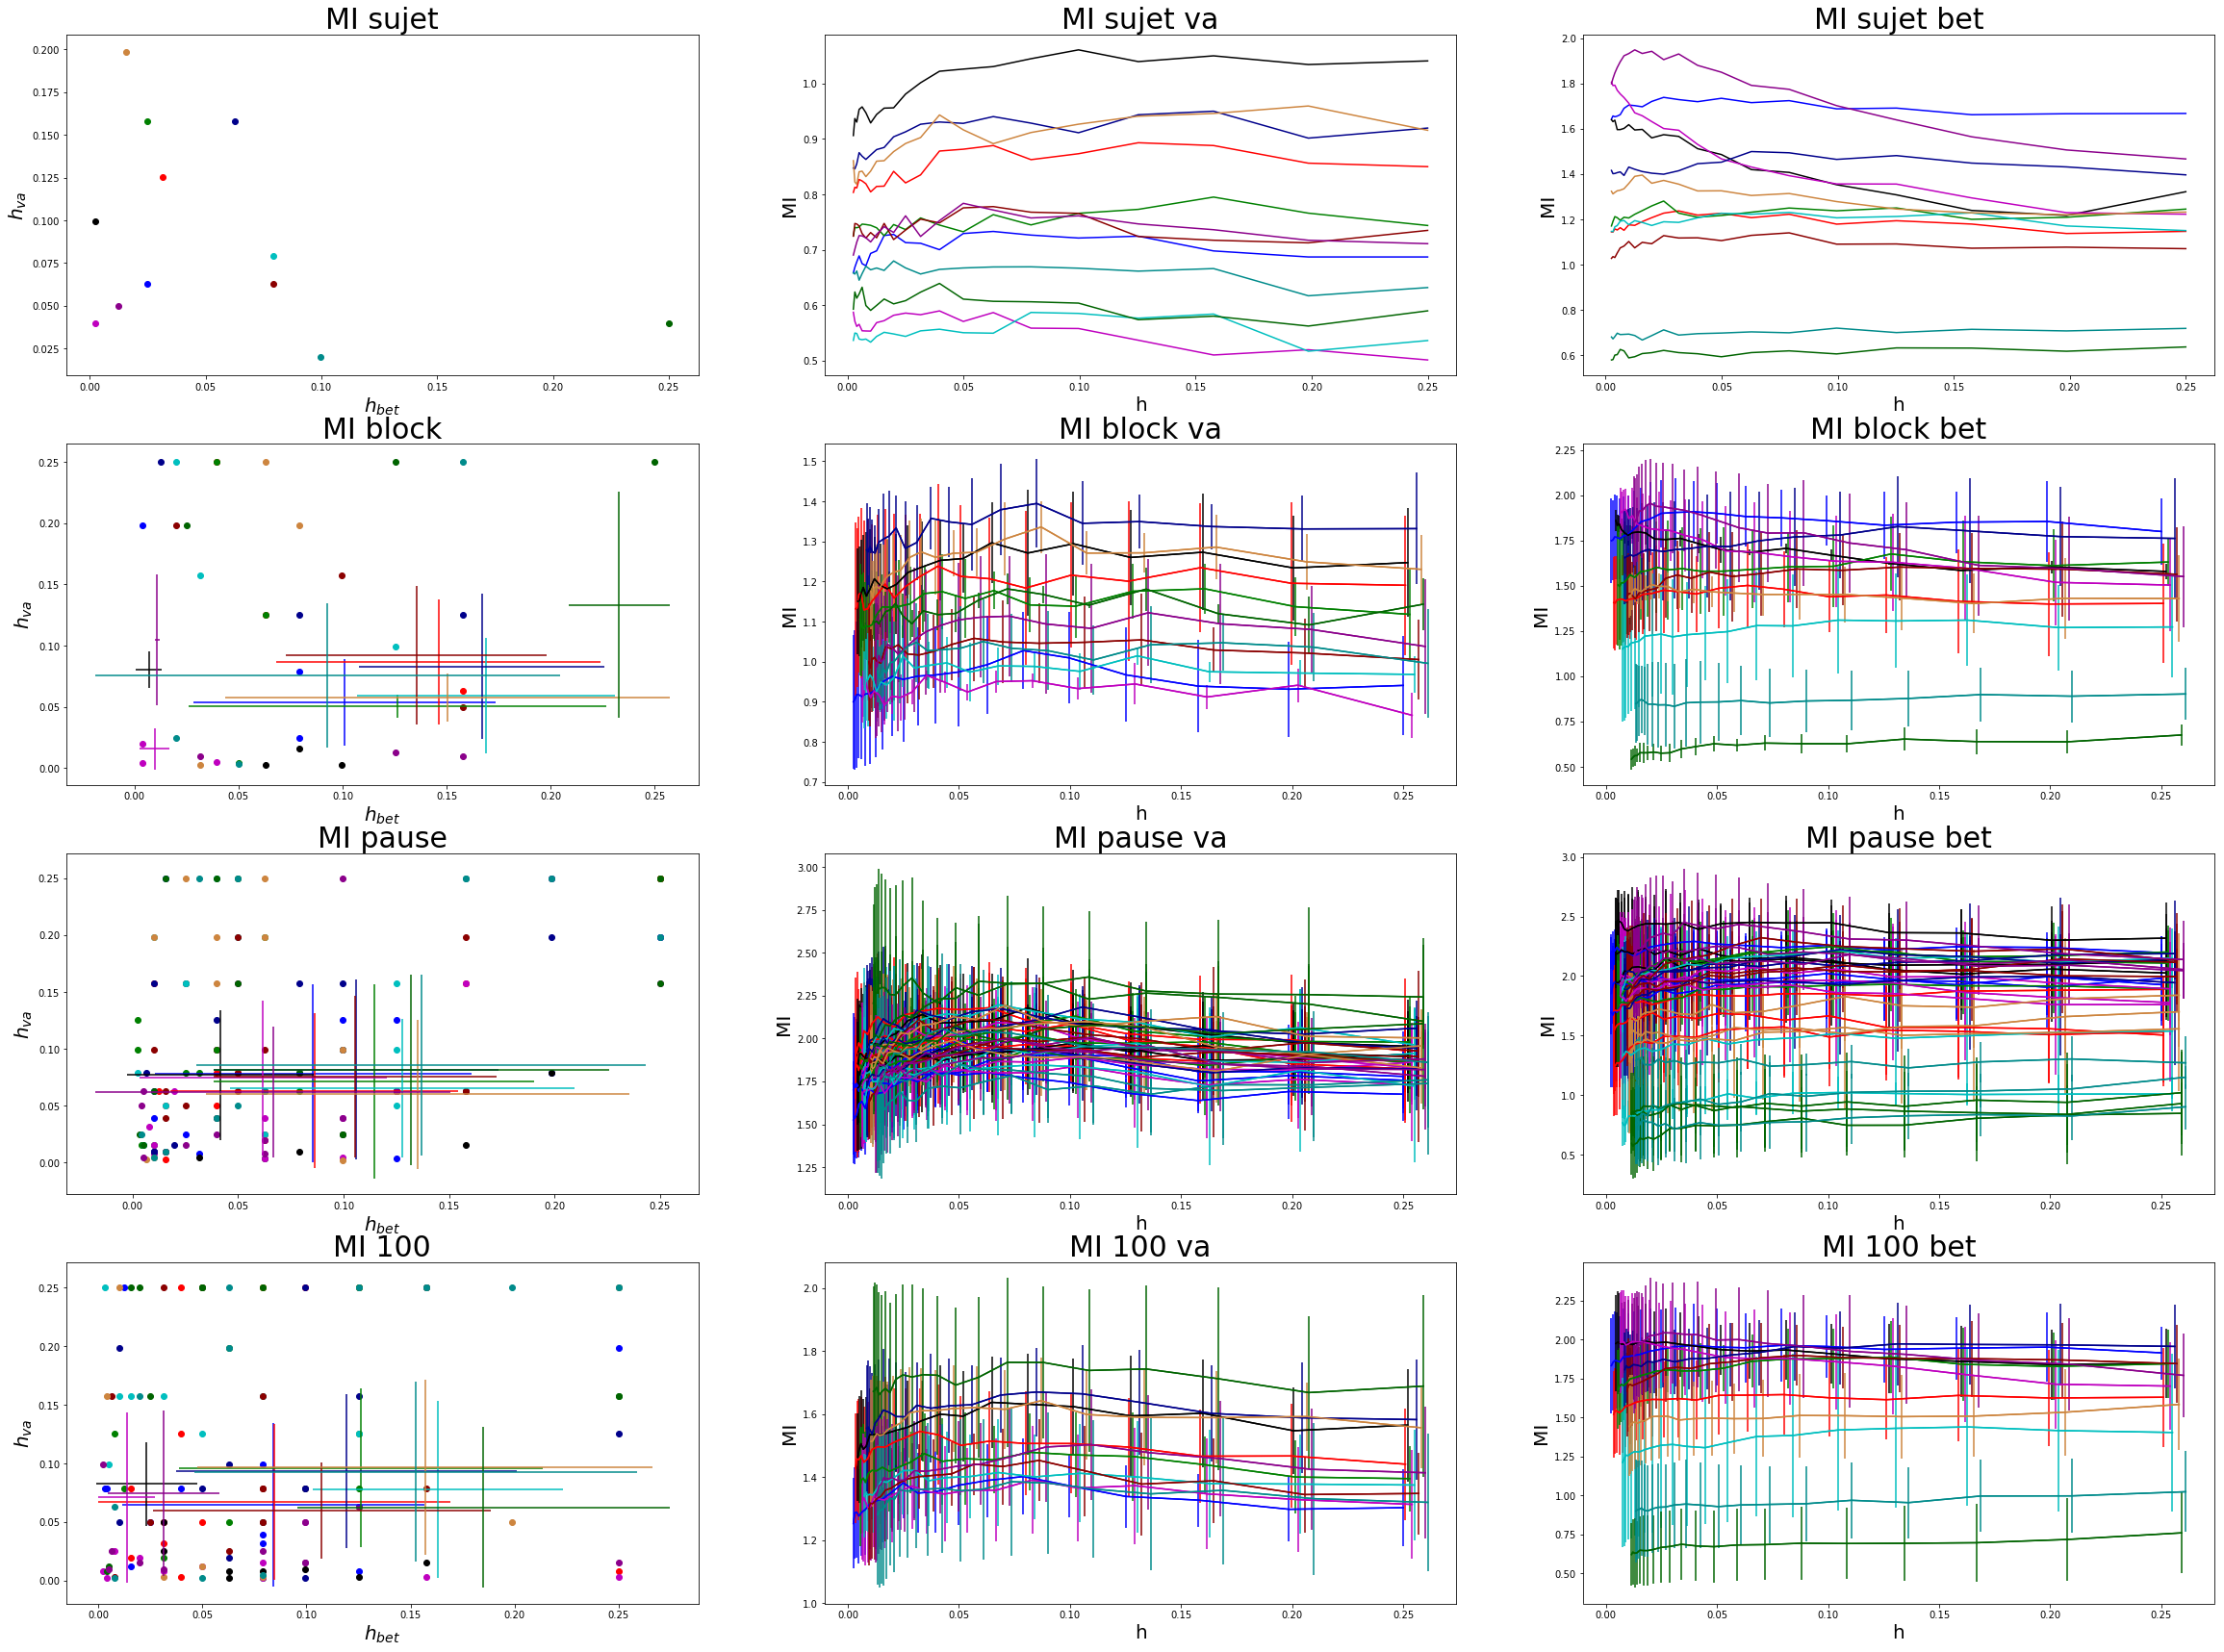

In [7]:
plot(regress='MI')

BMC FM SR DC AM OP LB CS TN YK IP RS 

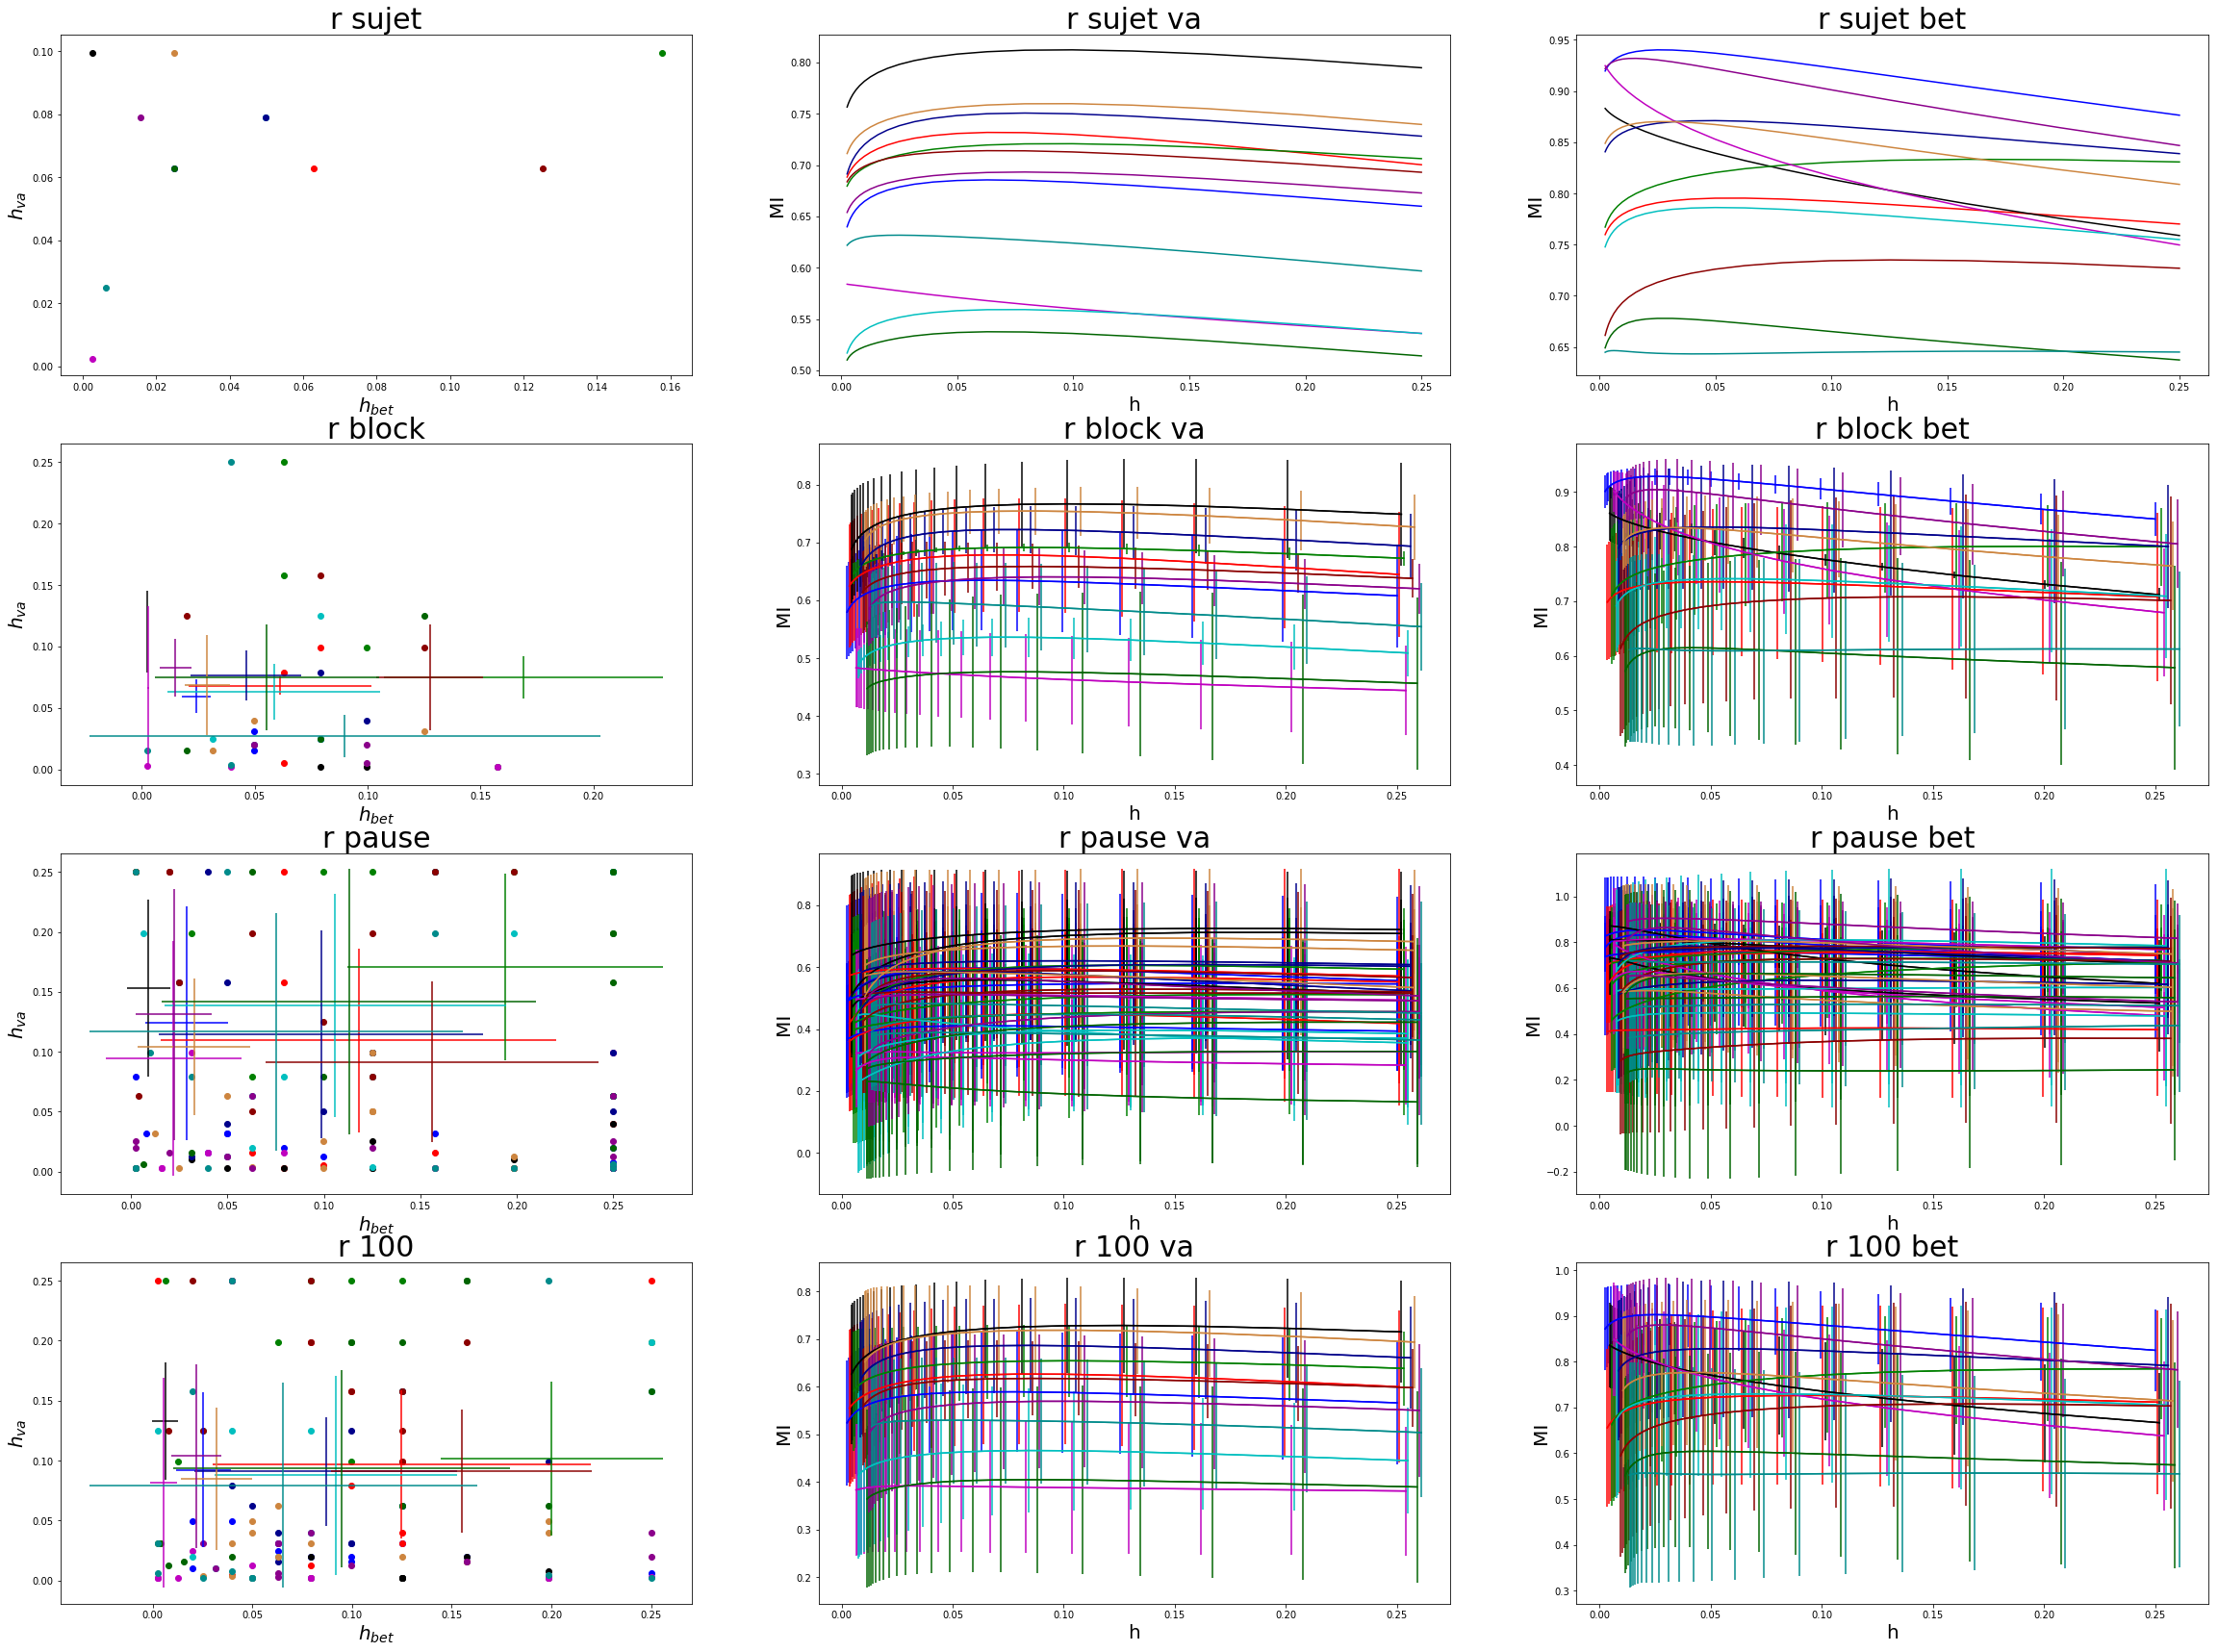

In [8]:
plot(regress='r')

In [35]:
def plot_r_100() :
    modes_bcp = 'mean'
    list_h = np.geomspace(0.0025, 0.25, 21)

    fig, ax = plt.subplots(1,3,figsize=(10*3,10*1))
    
    ax[0].set_title('r 100', fontsize=30)
    ax[0].set_xlabel('$h_{bet}$', fontsize=20) ; ax[0].set_xlim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax[0].set_ylabel('$h_{va}$', fontsize=20)  ; ax[0].set_ylim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    
    
    for b in range(1, 3) :
        ax[b].set_xlabel('h', fontsize=20) ; ax[b].set_xlim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
        ax[b].set_ylabel('r', fontsize=20)
        ax[b].set_xscale("log")
    ax[1].set_title('r va', fontsize=30)
    ax[2].set_title('r bet', fontsize=30)


    COLOR = ['b', 'r', 'k', 'g', 'm', 'c',
             'darkblue', 'darkred', 'peru', 'darkgreen', 'darkmagenta', 'darkcyan']


    for num, s in enumerate(set(Full.sujet)) :
        print(s, end=' ')
        va = Full['va'][Full.sujet==s].values.tolist()
        bet = Full['results'][Full.sujet==s].values.tolist()
        x = np.array(Full['bino'][Full.sujet==s].values.tolist())

        mi_va_100, mi_bet_100 = [], []
        for c in range(0, 3*200-50, 50) : mi_va_100.append([]) ; mi_bet_100.append([])
        
        for num_h, h in enumerate(list_h) :
            
            for d, c in enumerate(range(0, 3*200-50, 50)) :
                x_100 = x[c:c+100]
                p_hat_100 = np.zeros(100)

                liste = [0, 50, 100]
                for a in range(len(liste)-1) :
                    p_bar, r_bar, beliefs = bcp.inference(x_100[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                    p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                    p_hat_100[liste[a]:liste[a+1]] = p_hat_p

                mi_va_100[d].append(r_(p_hat_100.tolist(), va[c:c+100]))
                mi_bet_100[d].append(r_(p_hat_100.tolist(), bet[c:c+100]))

        h_va_100, h_bet_100 = [], []
        for d, c in enumerate(range(0, 3*200-50, 50)) :
            h_va_100.append(list_h[np.argmax(mi_va_100[d])] if np.argmax(mi_va_100[d]) > 0.6 else np.nan)
            h_bet_100.append(list_h[np.argmax(mi_bet_100[d])] if np.argmax(mi_bet_100[d]) > 0.6 else np.nan)
            
        
        ax[0].scatter(h_va_100, h_bet_100, c=COLOR[num])
        ax[0].plot(np.arange(-10,10), np.arange(-10,10), '--k')
        ax[0].vlines(0.025, 0, 0.025, colors='k')
        ax[0].hlines(0.025, 0, 0.025, colors='k')
        #ax[0].errorbar(np.mean(h_bet_100), np.mean(h_va_100), xerr=np.std(h_bet_100), yerr=np.std(h_va_100), c=COLOR[num])

        ax[1].plot(list_h, np.mean(mi_va_100, axis=0), c=COLOR[num])
        ax[1].errorbar(list_h, np.mean(mi_va_100, axis=0), yerr=np.std(mi_va_100, axis=0), c=COLOR[num])

        ax[2].plot(list_h, np.mean(mi_bet_100, axis=0), c=COLOR[num])
        ax[2].errorbar(list_h, np.mean(mi_bet_100, axis=0), yerr=np.std(mi_bet_100, axis=0), c=COLOR[num])


BMC FM SR DC AM OP LB CS TN YK IP RS 

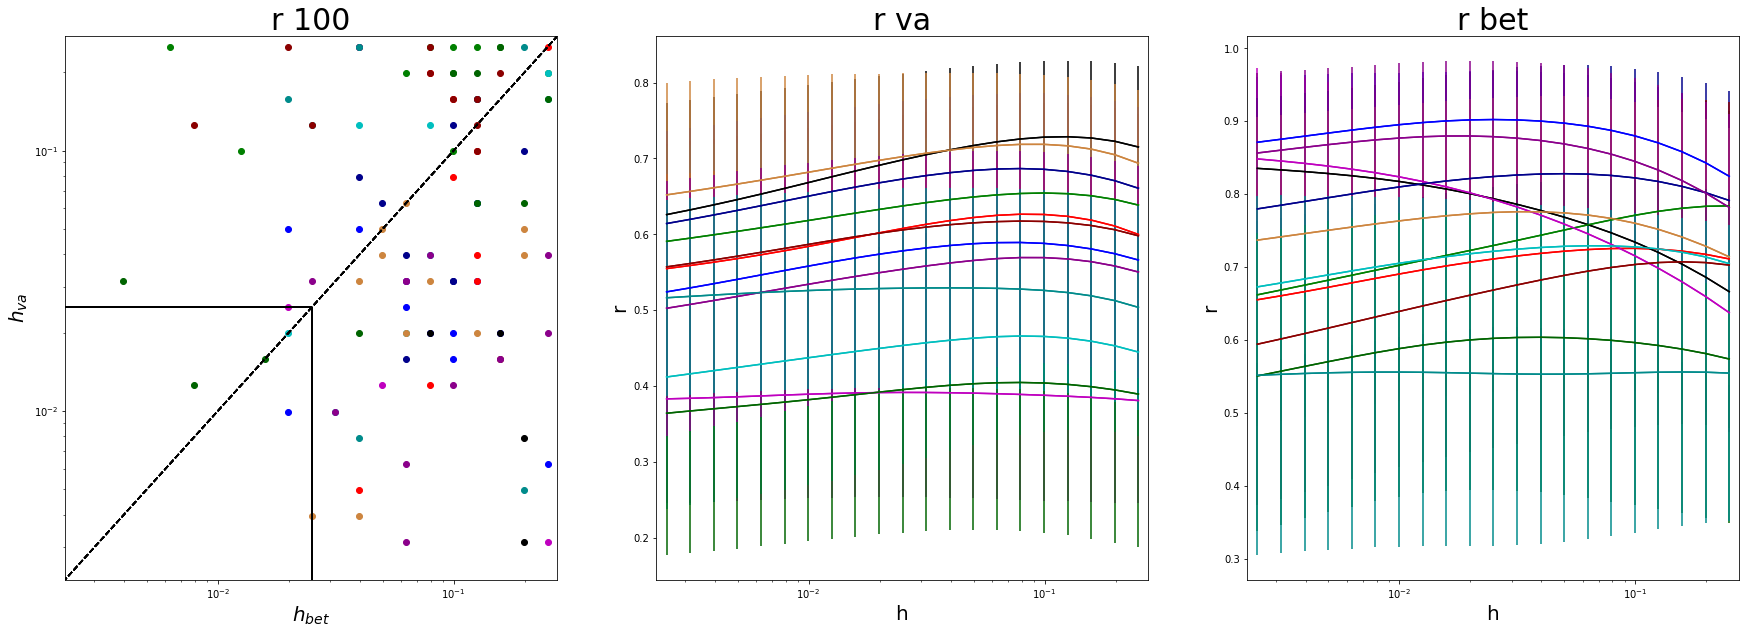

In [36]:
plot_r_100()